<h1 align="center">Direct Invite Prediction</h1>

<p>This is an attempt to predict Valve's Directe invites, for that the algorithm (Random Forest) takes into account 4 features : </p>


* Tournament : Number of lans won between the previous major and the announcement of the invites for the next major
* Major : Previous Major won or not
* Place : Place reached during the previous major
* Normalized Elo : Normalized elo score for games occured between the previous major (included) and the announcement of the invitations for the next major (lans only)

In [1]:
#  Some import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline
import time


plt.style.use(['ggplot','seaborn-notebook'])

In [2]:
# Load training data
fall = pd.read_csv("data/fall_2015.csv",index_col=0)
winter = pd.read_csv("data/winter_2016.csv",index_col=0)
spring = pd.read_csv("data/spring_2016.csv",index_col=0)
df = pd.concat([fall,winter,spring], ignore_index=True)
colums=["Major","Tournament","norm_elo"]
features= df[colums]
target = df.Invited.map({True:1,False:0})


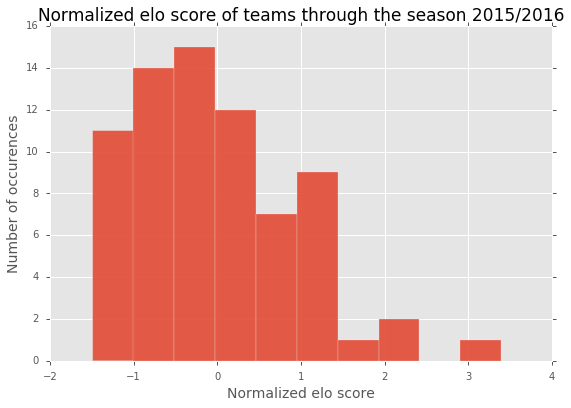

In [3]:
# Plot histogram of normalized elo score 
plt.figure(figsize=(9,6))
plt.hist(features.norm_elo,alpha=0.9)
plt.xlabel("Normalized elo score",fontsize=14)
plt.ylabel("Number of occurences",fontsize=14, rotation=90)
plt.title("Normalized elo score of teams through the season 2015/2016",fontsize=17)
plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode the places with real numbers
le = LabelEncoder()
le.fit(["1","2","3","4","5-6","7-8","9-12","13-16","17"])
features["place"]=le.transform(df.place)

c:\users\maverick\miniconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
le.classes_

array(['1', '13-16', '17', '2', '3', '4', '5-6', '7-8', '9-12'], 
      dtype='<U5')

In [6]:
from sklearn.cross_validation import train_test_split

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, test_size=0.33, random_state=42)

## Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

#Building model
rng = np.random.RandomState(31337)

rtf = RandomForestClassifier(random_state=rng)

parameters = {'n_estimators':[10,50,100,200],
             'max_depth':[2,6,4,8,10],
             'max_features':[None,"auto"],
             'criterion':['gini']}

grd = GridSearchCV(rtf,parameters,cv=2,verbose=1)

grd.fit(X_train,y_train)

time.sleep(1)
print(grd.best_score_ )
print(grd.best_params_)

Fitting 2 folds for each of 40 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    5.6s finished


0.916666666667
{'max_features': 'auto', 'criterion': 'gini', 'n_estimators': 10, 'max_depth': 2}


In [15]:
#Plot Confusion matrix
from sklearn.metrics import confusion_matrix
pred = grd.predict(X_test)
cm=confusion_matrix(y_test, pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized =np.around(cm_normalized,decimals=2)

cm_normalized

array([[ 0.88,  0.12],
       [ 0.  ,  1.  ]])

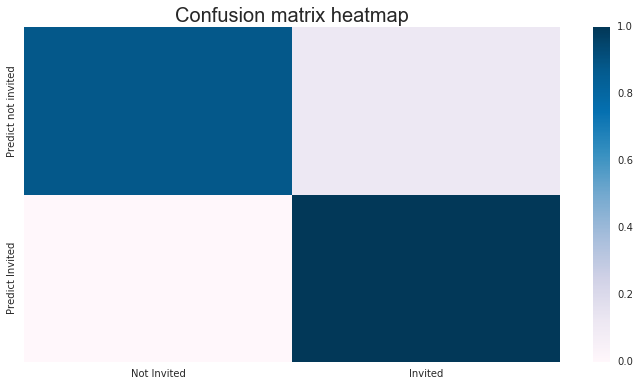

In [9]:
import seaborn as sns 

plt.figure(figsize=(12,6))
plt.title("Confusion matrix heatmap", fontsize=20)
ax = sns.heatmap(cm_normalized, yticklabels=["Predict not invited","Predict Invited"],xticklabels=["Not Invited","Invited"],
                cmap='PuBu')

The model built seems to be acceptable, we can expect to have good results for the TI6 invitations

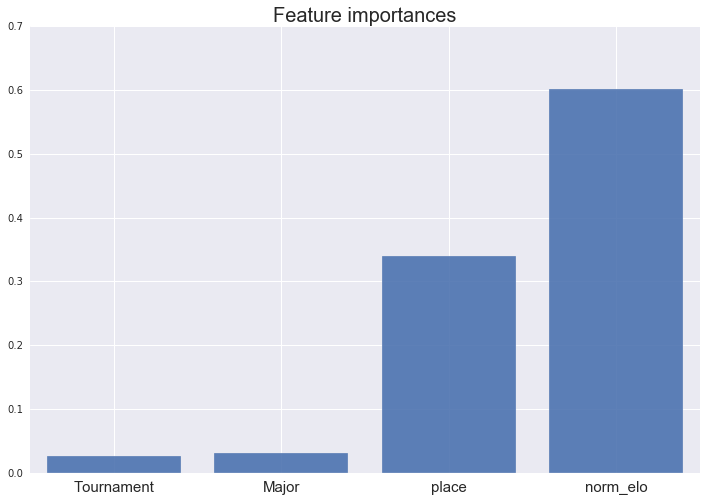

In [10]:
importances = grd.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,8))
plt.bar(range(features.shape[1]), importances[indices], align="center", alpha=0.9)
plt.title("Feature importances", fontsize=20)
plt.xticks(range(features.shape[1]), features.columns[indices], fontsize=15)
plt.show()


The graph just above show which features are the most important according to the random forest classifier.


## Predict TI6 Invites

In [11]:
ti = pd.read_csv("data/ti_2016.csv",index_col=0)

features=ti[colums]
features["place"]=le.transform(ti.place)
target = ti.Invited.map({True:1,False:0})

c:\users\maverick\miniconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# Prediction with Random Forest
pred=grd.predict(features.values)
cm=confusion_matrix(target.values, pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized =np.around(cm_normalized,decimals=2)
cm_normalized

array([[ 1.,  0.],
       [ 0.,  1.]])

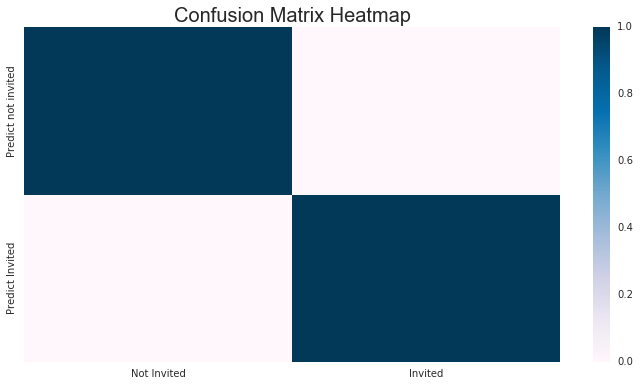

In [13]:
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix Heatmap", fontsize=20)
ax = sns.heatmap(cm_normalized, yticklabels=["Predict not invited","Predict Invited"],xticklabels=["Not Invited","Invited"],
                cmap='PuBu')

In [14]:
print("\n")
print("Invited teams for TI6:")
print("\n")
for i in range(len(pred)):
    if(pred[i]==1):
        print(ti.team.iloc[i])




Invited teams for TI6:


LGD Gaming
Newbee
OG
Team Liquid
MVP Phoenix
Natus Vincere


Teams invited by Valve:

* OG
* Team Liquid
* Newbee
* LGD Gaming
* MVP Phoenix
* Natus Vincere